In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from ipywidgets import interact

from dataset import MyData
from model import Net
from config import device
from helpgauss import default_train
from helper import prepare_gpr_results

IMG_SIZE = (50, 100)

Selected devie is cuda:0


# TEST 1

#### Here i use random samples from GP model

## 1. Full boundary

In [1]:
PATH_TO_TEST_RESULTS = './Tests/results_for_SingleNet1/full/'

### Sampling

Training: 100%|██████████| 100/100 [00:04<00:00, 23.19it/s]


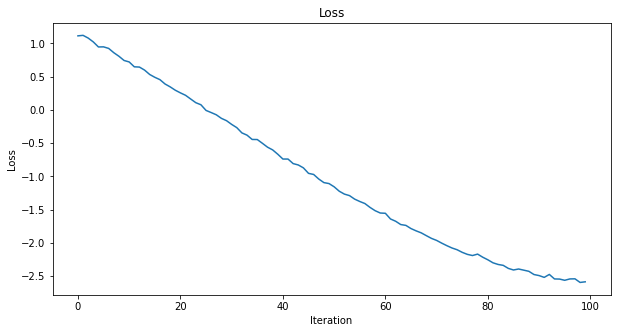

In [7]:
model, x_test = default_train()

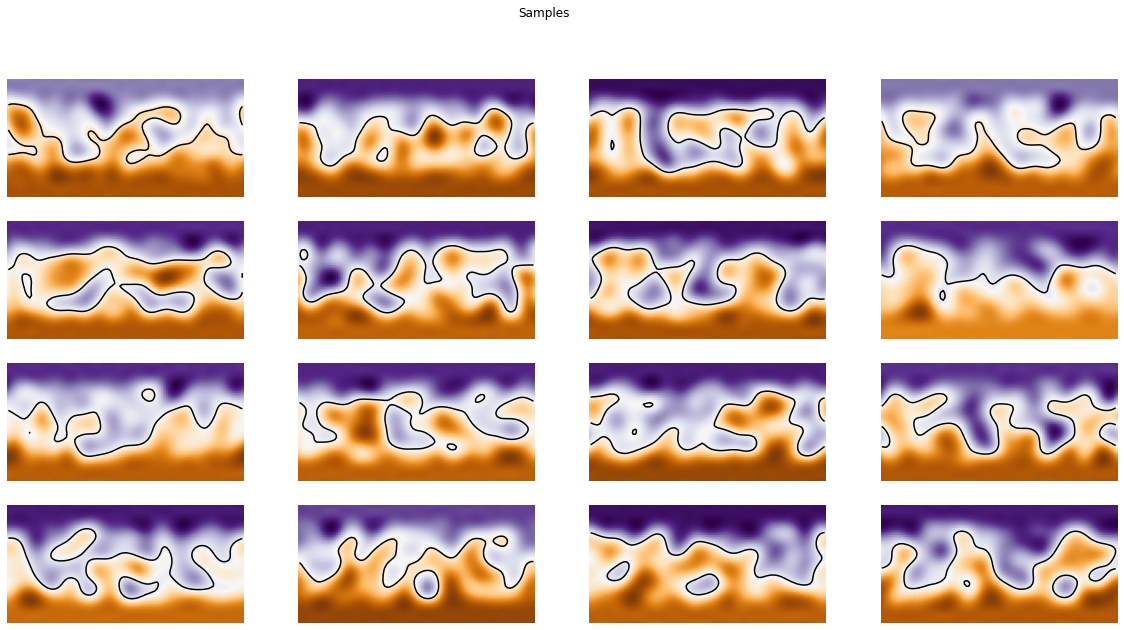

In [8]:
samples = model.predict(x_test.to(device), num_samples=1000, need_plot=True)
samples = samples.view(-1, *IMG_SIZE).cpu().detach()

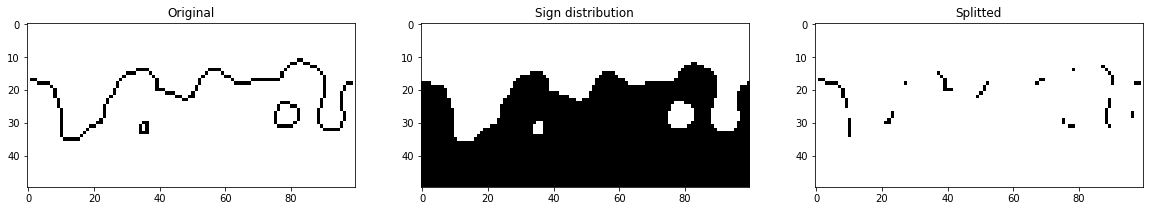

In [10]:
original, sign, splitted = prepare_gpr_results(samples[1], x_parts=5, scale_coef=0.85, color=0, need_plot=True)

### Experiment


#### Training loop

In [26]:
os.makedirs(PATH_TO_TEST_RESULTS, exist_ok=True)
with open(os.path.join(PATH_TO_TEST_RESULTS, 'res.txt'), 'w') as f:
    for i, sample in enumerate(tqdm(samples)):
        # make a directory for every sample
        cur_dir = os.path.join(PATH_TO_TEST_RESULTS, str(i + 1))
        os.mkdir(cur_dir)
        original, sign, _ = prepare_gpr_results(sample, x_parts=5, scale_coef=0.85, color=0, need_plot=False)
        f.write(f'sample {i+1}:\n')
        for k in range(4):
            dataset = MyData(path_or_img=original, data_mode='img', mode_3d='cylinder', radius=1, reduce_fctor=1, need_info=False)
            dataset_list = [dataset]
            model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
            model.to(device)
            if not k:
                model.load_state_dict(torch.load('./pretrained_model.pt'))
            model.start_training(num_epochs=15e+3, my_weight=0.1, need_save=False, need_plot=False)
            predictions = model.test_model(need_plot=False)
            prediction = predictions[0].view(*IMG_SIZE).cpu().detach()
            a = (prediction > 0).float()
            mae = float(((sign.float() - a).abs()).mean())
            # plot and save the result without plot
            plt.figure(figsize=(20, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(sign, cmap='PuOr')
            plt.title('Original')
            plt.subplot(1, 2, 2)
            plt.imshow(prediction > 0, cmap='PuOr')
            plt.title('Prediction {}\nMAE: {:.2f}'.format(k + 1, mae))
            plt.savefig(os.path.join(cur_dir, f'result_{k + 1}.png'), facecolor='white')
            plt.close()
            plt.clf()
            model.save_state_dict(os.path.join(cur_dir, f'model_{k + 1}.pth'))
            f.write(f'MAE_{k + 1}: {mae:.2f}\n')
        f.write('\n')

100%|██████████| 100/100 [9:28:42<00:00, 341.22s/it] 


<Figure size 432x288 with 0 Axes>

### Metrics analysis

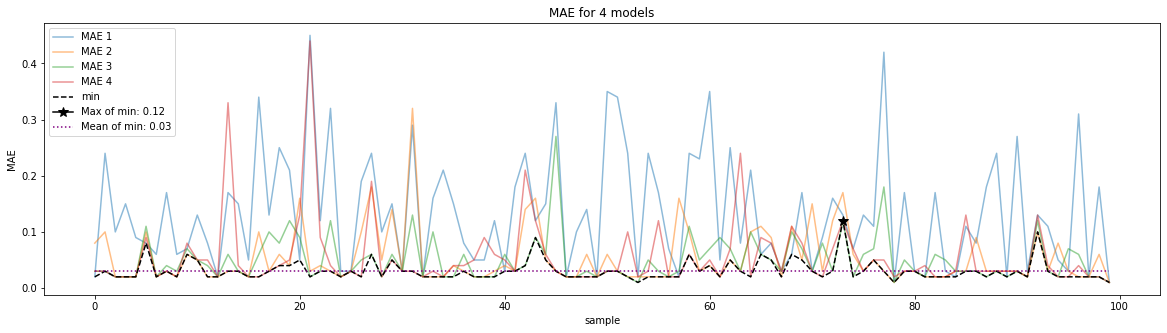

In [66]:
res = []
with open('results_for_SingleNet/res.txt', 'r') as f:
    for line in f:
        if line.startswith('sample'):
            res.append([])
        if line.startswith('MAE'):
            res[-1].append(float(line.split(': ')[1]))
res = np.array(res)
res_min = res.min(axis=1)

# plot res as 4 lines in one plot
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.plot(res[:, i], label=f'MAE {i + 1}', alpha=0.5)
plt.xlabel('sample')
plt.ylabel('MAE')
plt.plot(res_min, label='min', color='black', linestyle='--')
# plot maximun of res_min with star and label
plt.plot(res_min.argmax(), res_min.max(), marker='*', markersize=10, label=f'Max of min: {res_min.max():.2f}', color='black')
# plot mean line of res_min
plt.plot([0, 99], [res_min.mean(), res_min.mean()], label=f'Mean of min: {res_min.mean():.2f}', color='purple', linestyle='dotted')
plt.title('MAE for 4 models')
plt.legend()


## 2. Splitted boundary

### Sampling

Training: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


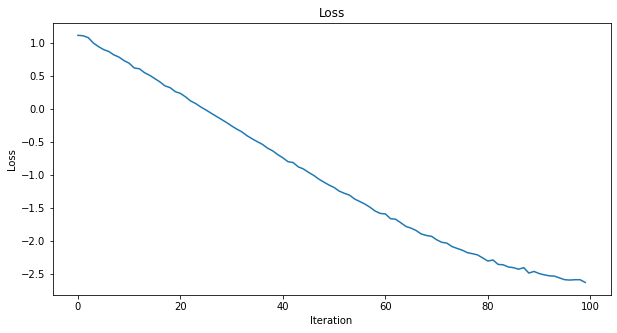

In [2]:
model, x_test = default_train()

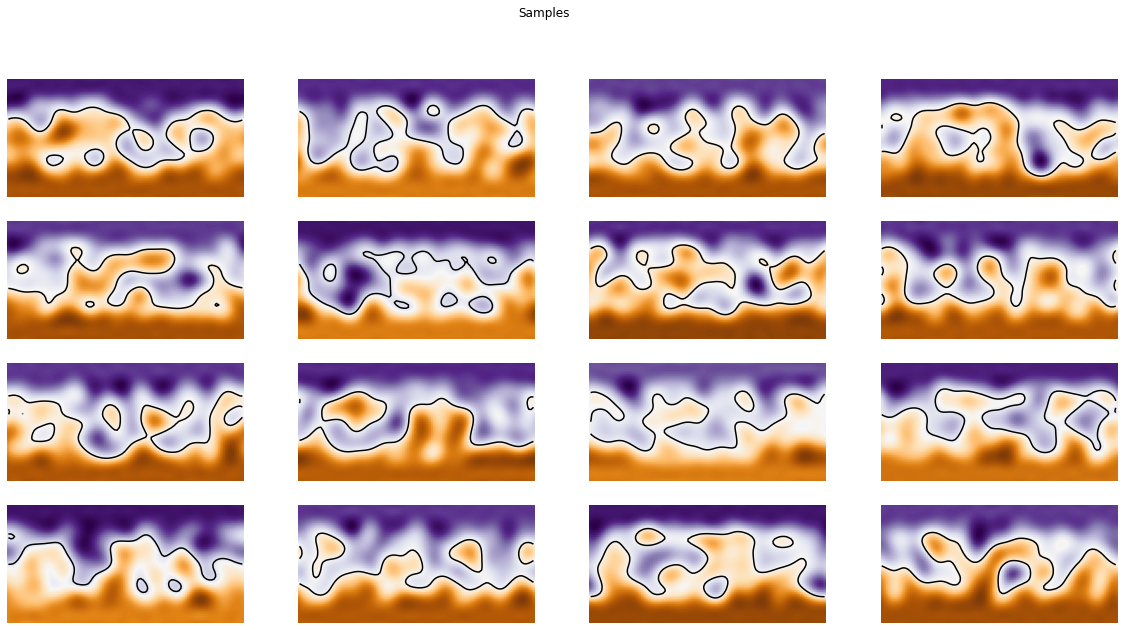

In [3]:
samples = model.predict(x_test.to(device), num_samples=100, need_plot=True)
samples = samples.view(-1, *IMG_SIZE).cpu().detach()

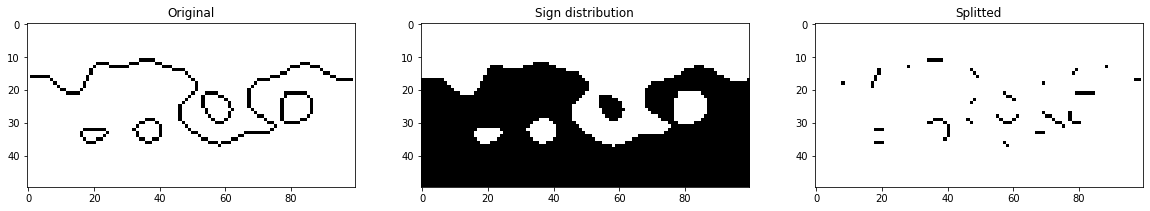

In [4]:
original, sign, splitted = prepare_gpr_results(samples[0], x_parts=5, scale_coef=0.85, color=0, need_plot=True)

### Experiment

In [2]:
PATH_TO_TEST_RESULTS = './Tests/results_for_SingleNet/splitted/'

#### Training loop

In [ ]:
os.makedirs(PATH_TO_TEST_RESULTS, exist_ok=True)
with open(os.path.join(PATH_TO_TEST_RESULTS, 'res.txt'), 'w') as f:
    for i, sample in enumerate(tqdm(samples)):
        # make a directory for every sample
        cur_dir = os.path.join(PATH_TO_TEST_RESULTS, str(i + 1))
        os.mkdir(cur_dir)
        original, sign, splitted = prepare_gpr_results(sample, x_parts=5, scale_coef=0.85, color=0, need_plot=False)
        f.write(f'sample {i+1}:\n')
        for k in range(4):
            dataset = MyData(path_or_img=splitted, data_mode='img', mode_3d='cylinder', radius=1, reduce_fctor=1, need_info=False)
            dataset_list = [dataset]
            model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
            model.to(device)
            model.start_training(num_epochs=20e+3, my_weight=0.1, need_save=False, need_plot=False)
            predictions = model.test_model(need_plot=False)
            prediction = predictions[0].view(*IMG_SIZE).cpu().detach()
            a = (prediction > 0).float()
            mae = float(((sign.float() - a).abs()).mean())
            # plot and save the result without plot
            plt.figure(figsize=(20, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(sign, cmap='PuOr')
            plt.title('Original')
            plt.subplot(1, 3, 2)
            plt.imshow(splitted, cmap='gray')
            plt.title('Splitted')
            plt.subplot(1, 3, 3)
            plt.imshow(prediction > 0, cmap='PuOr')
            plt.title('Prediction {}\nMAE: {:.2f}'.format(k + 1, mae))
            plt.savefig(os.path.join(cur_dir, f'result_{k + 1}.png'), facecolor='white')
            plt.close()
            plt.clf()
            model.save_state_dict(os.path.join(cur_dir, f'model_{k + 1}.pth'))
            f.write(f'MAE_{k + 1}: {mae:.2f}\n')
        f.write('\n')

### Metrics analysis

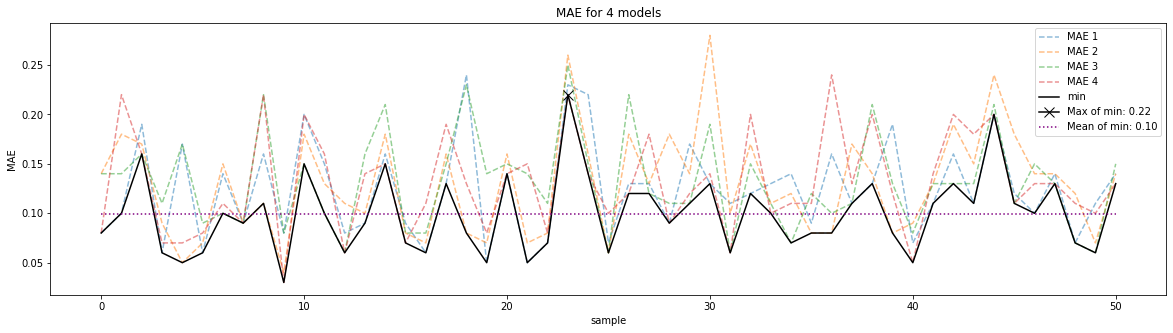

In [20]:
res = []
with open(os.path.join(PATH_TO_TEST_RESULTS, 'res.txt'), 'r') as f:
    for line in f:
        if line.startswith('sample'):
            res.append([])
        if line.startswith('MAE'):
            res[-1].append(float(line.split(': ')[1]))

res = np.array(res)
res_min = res.min(axis=1)

# plot res as 4 lines in one plot
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.plot(res[:, i], label=f'MAE {i + 1}', alpha=0.5, linestyle='--')
plt.xlabel('sample')
plt.ylabel('MAE')
plt.plot(res_min, label='min', color='black')
# plot maximun of res_min with star and label 
plt.plot(res_min.argmax(), res_min.max(), marker='x', markersize=10, label=f'Max of min: {res_min.max():.2f}', color='black')
# plot mean line of res_min
plt.plot([0, 50], [res_min.mean(), res_min.mean()], label=f'Mean of min: {res_min.mean():.2f}', color='purple', linestyle='dotted')
plt.title('MAE for 4 models')

plt.legend()

# TEST 2

#### Here i use first 100 'good' samples from GP model

## Load data

In [67]:
samples = torch.load('accepted_samples.pt')
samples = samples[:100]

### Plot signs

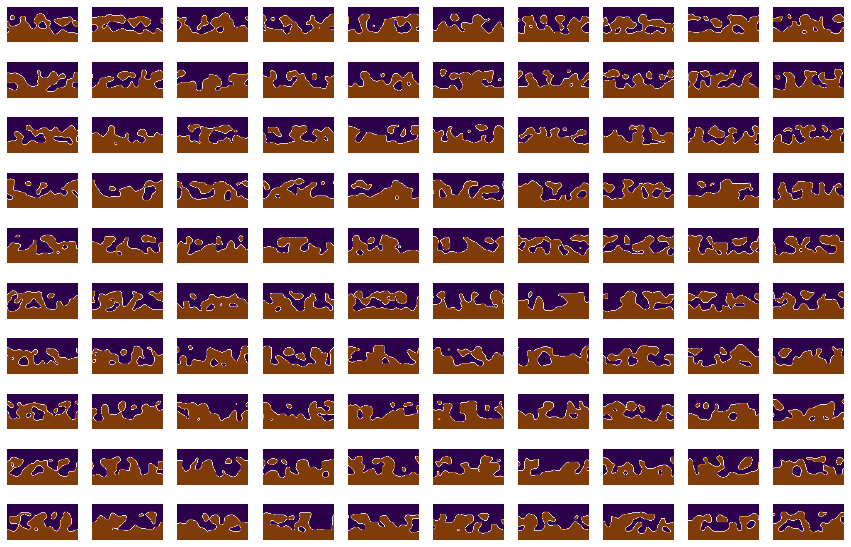

In [89]:
plt.figure(figsize=(15, 10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(samples[i] > 0, cmap='PuOr')
    # plt.title(i + 1)
    plt.axis('off')


### Plot splitted

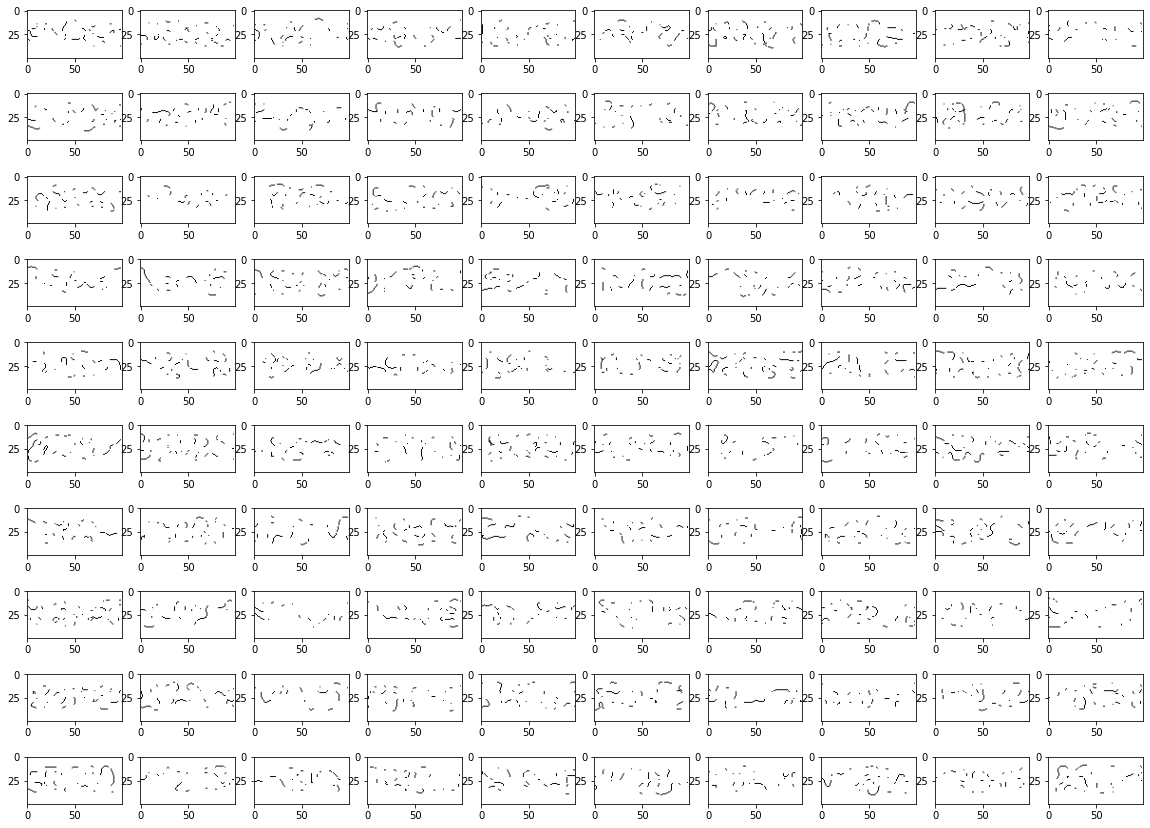

In [93]:
plt.figure(figsize=(20, 15))
for i in range(100):
    *_, splitted = prepare_gpr_results(samples[i], x_parts=5, scale_coef=0.85, color=0, need_plot=False)
    plt.subplot(10, 10, i + 1)
    plt.imshow(splitted, cmap='gray')

## Experiment

In [2]:
PATH_TO_TEST_RESULTS = './Tests/results_for_SingleNet_good/'

### Training loop

In [98]:
os.makedirs(PATH_TO_TEST_RESULTS, exist_ok=True)
with open(os.path.join(PATH_TO_TEST_RESULTS, 'res.txt'), 'w') as f:
    for i, sample in enumerate(tqdm(samples, desc='samples')):
        # make a directory for every sample
        cur_dir = os.path.join(PATH_TO_TEST_RESULTS, str(i + 1))
        os.mkdir(cur_dir)
        original, sign, splitted = prepare_gpr_results(sample, x_parts=5, scale_coef=0.85, color=0, need_plot=False)
        f.write(f'sample {i+1}:\n')
        for k in range(4):
            dataset = MyData(path_or_img=splitted, data_mode='img', mode_3d='cylinder', radius=1, reduce_fctor=1, need_info=False)
            dataset_list = [dataset]
            model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
            model.to(device)
            model.start_training(num_epochs=20e+3, my_weight=0.1, need_save=False, need_plot=False)
            predictions = model.test_model(need_plot=False)
            prediction = predictions[0].view(*IMG_SIZE).cpu().detach()
            a = (prediction > 0).float()
            mae = float(((sign.float() - a).abs()).mean())
            # plot and save the result without plot
            plt.figure(figsize=(20, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(sign, cmap='PuOr')
            plt.title('Original')
            plt.subplot(1, 3, 2)
            plt.imshow(splitted, cmap='gray')
            plt.title('Splitted')
            plt.subplot(1, 3, 3)
            plt.imshow(prediction > 0, cmap='PuOr')
            plt.title('Prediction {}\nMAE: {:.2f}'.format(k + 1, mae))
            plt.savefig(os.path.join(cur_dir, f'result_{k + 1}.png'), facecolor='white')
            plt.close()
            plt.clf()
            model.save_state_dict(os.path.join(cur_dir, f'model_{k + 1}.pth'))
            f.write(f'MAE_{k + 1}: {mae:.2f}\n')
        f.write('\n')

samples: 100%|██████████| 100/100 [12:02:52<00:00, 433.73s/it] 


<Figure size 432x288 with 0 Axes>

### Metrics analysis

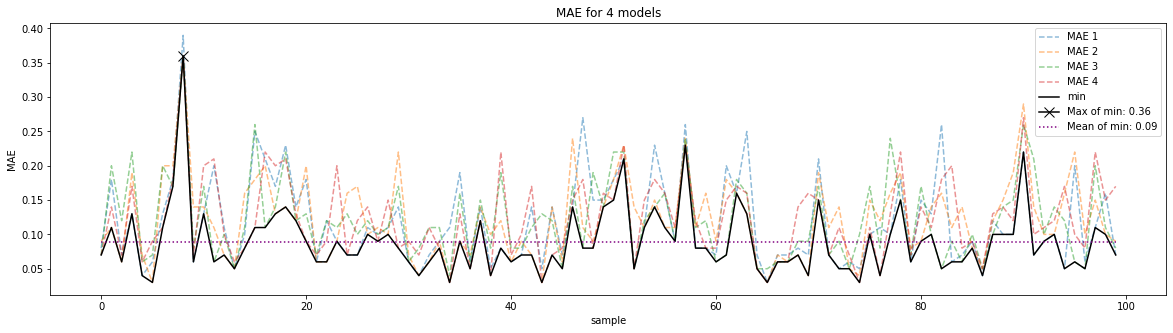

In [4]:
res = []
with open(os.path.join(PATH_TO_TEST_RESULTS, 'res.txt'), 'r') as f:
    for line in f:
        if line.startswith('sample'):
            res.append([])
        if line.startswith('MAE'):
            res[-1].append(float(line.split(': ')[1]))

res = np.array(res)
res_min = res.min(axis=1)

# plot res as 4 lines in one plot
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.plot(res[:, i], label=f'MAE {i + 1}', alpha=0.5, linestyle='--')
plt.xlabel('sample')
plt.ylabel('MAE')
plt.plot(res_min, label='min', color='black')
# plot maximun of res_min with star and label 
plt.plot(res_min.argmax(), res_min.max(), marker='x', markersize=10, label=f'Max of min: {res_min.max():.2f}', color='black')
# plot mean line of res_min
plt.plot([0, 99], [res_min.mean(), res_min.mean()], label=f'Mean of min: {res_min.mean():.2f}', color='purple', linestyle='dotted')
plt.title('MAE for 4 models')

plt.legend()

# FINAL TEST

In [21]:
def test_me(samples, stage, p):
    path = os.path.join('./Tests/_FINAL', stage)
    os.makedirs(path, exist_ok=True)
    with open(os.path.join(path, 'res.txt'), 'w') as f:
        for i, sample in enumerate(tqdm(samples, desc='samples')):
            # make a directory for every sample
            cur_dir = os.path.join(path, str(i + 1))
            os.mkdir(cur_dir)
            _, sign, splitted = prepare_gpr_results(img=sample, p=p, need_plot=False)
            f.write(f'sample {i+1}:\n')
            for k in range(5):
                dataset = MyData(path_or_img=splitted, data_mode='img', mode_3d='cylinder', radius=1, reduce_fctor=1, need_info=False)
                dataset_list = [dataset]
                model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
                model.to(device)
                model.start_training(num_epochs=15e+3, my_weight=0.1, need_save=False, need_plot=False)
                predictions = model.test_model(need_plot=False)
                prediction = predictions[0].view(*IMG_SIZE).cpu().detach()
                a = (prediction > 0).float()
                mae = float(((sign.float() - a).abs()).mean())
                # plot and save the result without plot
                plt.figure(figsize=(20, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(sign, cmap='PuOr')
                plt.title('Original')
                plt.subplot(1, 3, 2)
                plt.imshow(splitted, cmap='gray')
                plt.title('Splitted')
                plt.subplot(1, 3, 3)
                plt.imshow(prediction > 0, cmap='PuOr')
                plt.title('Prediction {}\nError: {:.2f}'.format(k + 1, mae))
                plt.savefig(os.path.join(cur_dir, f'result_{k + 1}.png'), facecolor='white')
                plt.close()
                plt.clf()
                model.save_state_dict(os.path.join(cur_dir, f'model_{k + 1}.pth'))
                f.write(f'Error_{k + 1}: {mae:.2f}\n')
            f.write('\n')

In [22]:
samples = torch.load('./Tests/_FINAL/samples.pt')

## Full boundary

In [8]:
test_me(stage='0B', p=0, samples=samples)

samples: 100%|██████████| 100/100 [10:06:26<00:00, 363.87s/it]


<Figure size 432x288 with 0 Axes>

## Erase 50% if boundary

In [9]:
test_me(stage='50B', p=0.5, samples=samples)

## Erase 65% of boundary

In [11]:
test_me(stage='65B', p=0.65, samples=samples)

## Erase 80% of boundary

In [15]:
test_me(stage='80B', p=0.8, samples=samples)

## Erase 90% of boundary

In [ ]:
test_me(stage='90B', p=0.9, samples=samples)

## Erase 95% of boundary

In [ ]:
test_me(stage='95B', p=0.95, samples=samples)